In [2]:
%cd /home/dev/24/es-bench

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path
import optuna
from ebes.pipeline.utils import optuna_df
from optuna.trial import TrialState

/home/dev/24/es-bench


log/mbd/mlem/data_scale_0.29077/results.csv  Failed


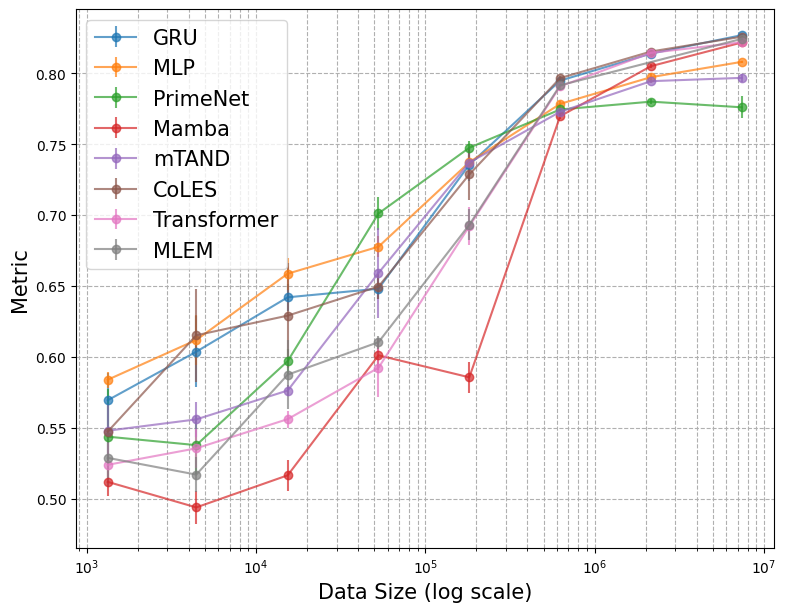

<Figure size 640x480 with 0 Axes>

In [5]:
import warnings
from omegaconf import OmegaConf

warnings.filterwarnings("ignore")

method_names = {
    "gru": "GRU",
    "mlp": "MLP",
    "primenet": "PrimeNet",
    "mamba": "Mamba",
    "mtand": "mTAND",
    "coles": "CoLES",
    "transformer": "Transformer",
    "mlem": "MLEM",
}
data_names = {
    "x5": "Retail",
    "mbd": "MBD",
}

dataset = "mbd"
scale_grid = (
    "0.00018 0.0006 0.00208 0.00715 0.02458 0.08454 0.29077 1.0".split(" ")
    if dataset == "mbd"
    else "0.004 0.013 0.038 0.114 0.338 1.0".split(" ")
)
full_size = 319127 if dataset == "x5" else 7398551

f = plt.figure(figsize=(9, 7))

# Initialize lists to store mean std across all methods
mean_std_x = []
mean_std_y = []

for method in method_names:
    x = []
    y = []
    y_err = []
    for scale in scale_grid:
        try:
            x_val = float(scale) * full_size
            res = pd.read_csv(
                f"log/{dataset}/{method}/data_scale_{scale}/results.csv", index_col=0
            )
            test_row = [row for row in res.index if "test" in row and "loss" not in row]
            res = res.loc[test_row, ["mean", "std"]]
            y.append(res["mean"].values[0])
            y_err.append(res["std"].values[0])
            x.append(x_val)

            # Add to mean std calculation
            if x_val not in mean_std_x:
                mean_std_x.append(x_val)
                mean_std_y.append(res["std"].values[0])
            else:
                idx = mean_std_x.index(x_val)
                mean_std_y[idx] += res["std"].values[0]
        except Exception as e:
            print(f"log/{dataset}/{method}/data_scale_{scale}/results.csv  Failed")
    plt.errorbar(x, y, yerr=y_err, fmt="-o", label=method_names[method], alpha=0.7)

# Calculate the mean std across all methods
mean_std_y = [std / len(method_names) for std in mean_std_y]

# Plot the mean std line
# plt.plot(mean_std_x, mean_std_y, 'k--', label='Mean Std Across All Methods')

plt.xlabel("Data Size (log scale)", fontsize=15)
plt.ylabel("Metric", fontsize=15)
# plt.title(f"{data_names[dataset]}. Metric progression with train data size")
plt.legend(fontsize=15)
plt.grid(True, which="both", ls="--")
plt.xscale("log")
plt.show()
plt.tight_layout()
f.savefig(f"notebooks/figures/scale_{dataset}.pdf")